<a href="https://colab.research.google.com/github/FernandoSimon22/vision_artificial/blob/main/Copia_de_Faster_R_CNN_implementacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="lX9sE2RPQOCv2R7cn0io")
project = rf.workspace("jota22").project("am_boundingbox")
version = project.version(14)
dataset = version.download("coco")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.2 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to AM_BoundingBox-14 in coco:: 100%|██████████| 198/198 [00:00<00:00, 5509.23it/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json

# Ruta al archivo original
ruta_entrada = "/content/AM_BoundingBox-14/test/_annotations.coco.json"

# Ruta al nuevo archivo corregido
ruta_salida = "/content/AM_BoundingBox-14/test/_annotations_corregido.coco.json"

# Cargar el archivo JSON
with open(ruta_entrada, "r") as f:
    data = json.load(f)

# Corregir la categoría: poner solo una, con id = 0
data["categories"] = [
    {
        "id": 0,
        "name": "def",
        "supercategory": "none"
    }
]

# Cambiar todos los category_id: 1 → 0
for ann in data["annotations"]:
    if ann["category_id"] == 1:
        ann["category_id"] = 0

# Guardar el nuevo archivo corregido
with open(ruta_salida, "w") as f:
    json.dump(data, f)

print("✅ Archivo corregido guardado en:", ruta_salida)


✅ Archivo corregido guardado en: /content/AM_BoundingBox-14/test/_annotations_corregido.coco.json


In [3]:
import json

# Ruta al archivo original
ruta_entrada = "/content/AM_BoundingBox-14/train/_annotations.coco.json"

# Ruta al nuevo archivo corregido
ruta_salida = "/content/AM_BoundingBox-14/train/_annotations_corregido.coco.json"

# Cargar el archivo JSON
with open(ruta_entrada, "r") as f:
    data = json.load(f)

# Corregir la categoría: poner solo una, con id = 0
data["categories"] = [
    {
        "id": 0,
        "name": "def",
        "supercategory": "none"
    }
]

# Cambiar todos los category_id: 1 → 0
for ann in data["annotations"]:
    if ann["category_id"] == 1:
        ann["category_id"] = 0

# Guardar el nuevo archivo corregido
with open(ruta_salida, "w") as f:
    json.dump(data, f)

print("✅ Archivo corregido guardado en:", ruta_salida)


✅ Archivo corregido guardado en: /content/AM_BoundingBox-14/train/_annotations_corregido.coco.json


In [4]:
import json

# Ruta al archivo original
ruta_entrada = "/content/AM_BoundingBox-14/valid/_annotations.coco.json"

# Ruta al nuevo archivo corregido
ruta_salida = "/content/AM_BoundingBox-14/valid/_annotations_corregido.coco.json"

# Cargar el archivo JSON
with open(ruta_entrada, "r") as f:
    data = json.load(f)

# Corregir la categoría: poner solo una, con id = 0
data["categories"] = [
    {
        "id": 0,
        "name": "def",
        "supercategory": "none"
    }
]

# Cambiar todos los category_id: 1 → 0
for ann in data["annotations"]:
    if ann["category_id"] == 1:
        ann["category_id"] = 0

# Guardar el nuevo archivo corregido
with open(ruta_salida, "w") as f:
    json.dump(data, f)

print("✅ Archivo corregido guardado en:", ruta_salida)


✅ Archivo corregido guardado en: /content/AM_BoundingBox-14/valid/_annotations_corregido.coco.json


In [5]:
# Define transformations
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [6]:
# Dataset class
!pip install pycocotools

def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="/content/AM_BoundingBox-14/train",
    ann_file="/content/AM_BoundingBox-14/train/_annotations_corregido.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="/content/AM_BoundingBox-14/valid",
    ann_file="/content/AM_BoundingBox-14/valid/_annotations_corregido.coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [7]:
# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [8]:
# Initialize the model
num_classes = 2 # background + def
model = get_model(num_classes)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 196MB/s]


In [9]:
# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [10]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [11]:
# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()

    # Save the model's state dictionary every 10 epochs
    if (epoch + 1) % 15 == 0:
        model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
        torch.save(model.state_dict(), model_path)
        print(f"✅ Model saved: {model_path}")


Epoch [0] Loss: 0.3619
Epoch [1] Loss: 0.4051
Epoch [2] Loss: 0.3645
Epoch [3] Loss: 0.2495
Epoch [4] Loss: 0.3723
Epoch [5] Loss: 0.3083
Epoch [6] Loss: 0.3225
Epoch [7] Loss: 0.3349
Epoch [8] Loss: 0.3375
Epoch [9] Loss: 0.3191
Epoch [10] Loss: 0.2798
Epoch [11] Loss: 0.2683
Epoch [12] Loss: 0.3138
Epoch [13] Loss: 0.3210
Epoch [14] Loss: 0.2585
✅ Model saved: fasterrcnn_resnet50_epoch_15.pth
Epoch [15] Loss: 0.2763
Epoch [16] Loss: 0.2841
Epoch [17] Loss: 0.2369
Epoch [18] Loss: 0.3581
Epoch [19] Loss: 0.2917
Epoch [20] Loss: 0.3382
Epoch [21] Loss: 0.3609
Epoch [22] Loss: 0.2845
Epoch [23] Loss: 0.2800
Epoch [24] Loss: 0.2644
Epoch [25] Loss: 0.2959
Epoch [26] Loss: 0.2598
Epoch [27] Loss: 0.3399
Epoch [28] Loss: 0.2900
Epoch [29] Loss: 0.2904
✅ Model saved: fasterrcnn_resnet50_epoch_30.pth
Epoch [30] Loss: 0.2864
Epoch [31] Loss: 0.3242
Epoch [32] Loss: 0.3005
Epoch [33] Loss: 0.3084
Epoch [34] Loss: 0.2774
Epoch [35] Loss: 0.2704
Epoch [36] Loss: 0.3102
Epoch [37] Loss: 0.3461
Ep

In [12]:
# --- MEJORADO: Evaluar todas las imágenes del conjunto de validación y visualizar ---

import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import transforms

# --- CONFIGURACIÓN ---
num_classes = 2  # 1 clase + fondo
model_path = "/content/fasterrcnn_resnet50_epoch_150.pth"
img_dir = "/content/AM_BoundingBox-14/test"  # <-- Cambia esto si es necesario
ann_file = "/content/AM_BoundingBox-14/test/_annotations.coco.json"

# --- CARGAR MODELO ---
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(num_classes)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# --- COCO DATASET & LOADER ---
def get_transform():
    return transforms.Compose([
        transforms.ToTensor()
    ])

def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(root=img_dir, annFile=ann_file, transform=get_transform())

dataset = get_coco_dataset(img_dir, ann_file)
val_loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# --- FUNCIONES DE DIBUJO ---
COCO_CLASSES = {0: "background", 1: "def"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "unknown")

def draw_boxes(image, prediction, threshold=0.5):
    draw = ImageDraw.Draw(image)
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x_min, y_min, x_max, y_max = box
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=2)
            draw.text((x_min, y_min), f"{get_class_name(label)} ({score:.2f})", fill="red")
    return image

# --- EVALUAR Y GUARDAR RESULTADOS DE TODAS LAS IMÁGENES ---
out_dir = "detections"
os.makedirs(out_dir, exist_ok=True)

with torch.no_grad():
    for idx, (images, targets) in enumerate(tqdm(val_loader, desc="Evaluando")):
        image_tensor = images[0].to(device)
        output = model([image_tensor])[0]

        # Cargar imagen original para visualizar
        image_path = dataset.ids[idx]
        image_file = dataset.coco.loadImgs(image_path)[0]['file_name']
        image = Image.open(os.path.join(img_dir, image_file)).convert("RGB")

        # Dibujar predicciones
        result_img = draw_boxes(image.copy(), output)

        # Guardar
        result_img.save(os.path.join(out_dir, f"prediction_{idx+1}.jpg"))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Evaluando: 100%|██████████| 25/25 [00:00<00:00, 26.77it/s]


In [13]:
# --- FUNCIÓN PARA EVALUAR UN MODELO SOBRE TODO EL DATASET Y DEVOLVER MÉTRICAS ---

import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
import os
from PIL import Image, ImageDraw
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


def evaluate_model(model, val_loader, annotations_path, output_json="predictions.json", device="cuda"):
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    model.to(device)

    results = []
    total_box_loss = 0.0
    total_cls_loss = 0.0
    n_batches = 0

    # Recorrer dataset de validación
    with torch.no_grad(): # Fixed: Moved the 'with' statement to the correct indentation level.
       for batch_idx, (images, targets) in enumerate(tqdm(val_loader, desc="Evaluando modelo")):
            images = [img.to(device) for img in images]

             # 🔐 Filtrar solo targets válidos (que tengan 'boxes' y no estén vacíos)
            filtered_targets = []
            valid_images = [] # List to store valid images

            for i, t in enumerate(targets):
                if isinstance(t, dict) and 'boxes' in t and len(t['boxes']) > 0:
                    filtered_targets.append({k: v.to(device) for k, v in t.items()})
                    valid_images.append(images[i]) # Add corresponding image to valid_images

            if not filtered_targets:
                print(f"⚠️ [Batch {batch_idx}] No valid targets found in this batch: {targets}")
                continue # Skip to next batch if no valid targets

            # Update images list with valid images
            images = valid_images
            targets = filtered_targets

            # Calcular pérdidas (modo train necesario)
            # model.train()
            outputs = model(images)
            loss_dict = model(images, targets)
            total_box_loss += loss_dict['loss_box_reg'].item()
            total_cls_loss += loss_dict['loss_classifier'].item()
            # model.eval()

            outputs = model(images)

            for i in range(len(outputs)):
                if "image_id" in targets[i] and isinstance(targets[i]["image_id"], (int, torch.Tensor)):
                    image_id = targets[i]["image_id"].item() if isinstance(targets[i]["image_id"], torch.Tensor) else targets[i]["image_id"]
                else:
                    print(f"Warning: Skipping image without a valid 'image_id' in target: {targets[i]}") # Added warning message
                    continue
                boxes = outputs[i]["boxes"].cpu().numpy()
                scores = outputs[i]["scores"].cpu().numpy()
                labels = outputs[i]["labels"].cpu().numpy()

                for box, score, label in zip(boxes, scores, labels):
                    x1, y1, x2, y2 = box
                    results.append({
                        "image_id": image_id,
                        "category_id": int(label),
                        "bbox": [x1, y1, x2 - x1, y2 - y1],
                        "score": float(score)
                    })

            n_batches += 1

    # Guardar predicciones
    if not results:
        print("⚠️ No predictions found. Check model output or score threshold.")
        # If n_batches is 0, set it to 1 to avoid ZeroDivisionError
        n_batches = n_batches if n_batches > 0 else 1  # This line prevents the error
        return {
            "map": 0,
            "ap50": 0,
            "recall": 0,
            "box_loss": total_box_loss / n_batches,
            "cls_loss": total_cls_loss / n_batches,
        }
    else:
        with open(output_json, "w") as f:
            json.dump(results, f)

    # Evaluar con COCO
    coco_gt = COCO(annotations_path)
    coco_dt = coco_gt.loadRes(output_json)
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    return {
        "map": coco_eval.stats[0],
        "ap50": coco_eval.stats[1],
        "recall": coco_eval.stats[8],
        "box_loss": total_box_loss / n_batches,
        "cls_loss": total_cls_loss / n_batches
    }

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!

Evaluando modelo: /content/fasterrcnn_resnet50_epoch_105.pth


Evaluando modelo:  75%|███████▌  | 6/8 [00:00<00:00, 50.32it/s]

⚠️ [Batch 0] No valid targets found in this batch: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [321, 58, 14.67, 9.33], 'area': 136.871, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [375, 46, 20, 8.67], 'area': 173.4, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [437, 57, 16, 10], 'area': 160, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [409, 62, 18, 8.67], 'area': 156.06, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [507, 3, 16, 9.33], 'area': 149.28, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [550, 9, 14, 6], 'area': 84, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [593, 40, 11.33, 11.33], 'area': 128.369, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [539, 68, 20, 10], 'area': 200, 'segmenta

Evaluando modelo: 100%|██████████| 8/8 [00:00<00:00, 52.57it/s]


⚠️ [Batch 7] No valid targets found in this batch: ([{'id': 1292, 'image_id': 28, 'category_id': 1, 'bbox': [79, 607, 23.12, 20.15], 'area': 465.868, 'segmentation': [], 'iscrowd': 0}, {'id': 1293, 'image_id': 28, 'category_id': 1, 'bbox': [337, 194, 20.24, 21.87], 'area': 442.649, 'segmentation': [], 'iscrowd': 0}, {'id': 1294, 'image_id': 28, 'category_id': 1, 'bbox': [335, 104, 20.58, 16.3], 'area': 335.454, 'segmentation': [], 'iscrowd': 0}, {'id': 1295, 'image_id': 28, 'category_id': 1, 'bbox': [105, 232, 12.62, 18.05], 'area': 227.791, 'segmentation': [], 'iscrowd': 0}, {'id': 1296, 'image_id': 28, 'category_id': 1, 'bbox': [337, 304, 20.92, 13.9], 'area': 290.788, 'segmentation': [], 'iscrowd': 0}, {'id': 1297, 'image_id': 28, 'category_id': 1, 'bbox': [354, 241, 12.75, 18.88], 'area': 240.72, 'segmentation': [], 'iscrowd': 0}, {'id': 1298, 'image_id': 28, 'category_id': 1, 'bbox': [317, 74, 8.59, 23.55], 'area': 202.295, 'segmentation': [], 'iscrowd': 0}, {'id': 1299, 'image_id

Evaluando modelo:   0%|          | 0/8 [00:00<?, ?it/s]

⚠️ [Batch 0] No valid targets found in this batch: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [321, 58, 14.67, 9.33], 'area': 136.871, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [375, 46, 20, 8.67], 'area': 173.4, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [437, 57, 16, 10], 'area': 160, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [409, 62, 18, 8.67], 'area': 156.06, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [507, 3, 16, 9.33], 'area': 149.28, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [550, 9, 14, 6], 'area': 84, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [593, 40, 11.33, 11.33], 'area': 128.369, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [539, 68, 20, 10], 'area': 200, 'segmenta

Evaluando modelo: 100%|██████████| 8/8 [00:00<00:00, 53.96it/s]

⚠️ [Batch 1] No valid targets found in this batch: ([{'id': 247, 'image_id': 4, 'category_id': 1, 'bbox': [408, 286, 39.92, 9.38], 'area': 374.45, 'segmentation': [], 'iscrowd': 0}, {'id': 248, 'image_id': 4, 'category_id': 1, 'bbox': [452, 287, 47.14, 8.27], 'area': 389.848, 'segmentation': [], 'iscrowd': 0}, {'id': 249, 'image_id': 4, 'category_id': 1, 'bbox': [503, 288, 55.46, 8.16], 'area': 452.554, 'segmentation': [], 'iscrowd': 0}, {'id': 250, 'image_id': 4, 'category_id': 1, 'bbox': [565, 288, 26.34, 8.49], 'area': 223.627, 'segmentation': [], 'iscrowd': 0}, {'id': 251, 'image_id': 4, 'category_id': 1, 'bbox': [600, 289, 36.11, 8.83], 'area': 318.851, 'segmentation': [], 'iscrowd': 0}, {'id': 252, 'image_id': 4, 'category_id': 1, 'bbox': [28, 201, 15.99, 10.02], 'area': 160.22, 'segmentation': [], 'iscrowd': 0}, {'id': 253, 'image_id': 4, 'category_id': 1, 'bbox': [179, 296, 17.07, 9.13], 'area': 155.849, 'segmentation': [], 'iscrowd': 0}, {'id': 254, 'image_id': 4, 'category_id


Evaluando modelo: /content/fasterrcnn_resnet50_epoch_135.pth


Evaluando modelo: 100%|██████████| 8/8 [00:00<00:00, 52.62it/s]

⚠️ [Batch 0] No valid targets found in this batch: ([{'id': 0, 'image_id': 0, 'category_id': 1, 'bbox': [321, 58, 14.67, 9.33], 'area': 136.871, 'segmentation': [], 'iscrowd': 0}, {'id': 1, 'image_id': 0, 'category_id': 1, 'bbox': [375, 46, 20, 8.67], 'area': 173.4, 'segmentation': [], 'iscrowd': 0}, {'id': 2, 'image_id': 0, 'category_id': 1, 'bbox': [437, 57, 16, 10], 'area': 160, 'segmentation': [], 'iscrowd': 0}, {'id': 3, 'image_id': 0, 'category_id': 1, 'bbox': [409, 62, 18, 8.67], 'area': 156.06, 'segmentation': [], 'iscrowd': 0}, {'id': 4, 'image_id': 0, 'category_id': 1, 'bbox': [507, 3, 16, 9.33], 'area': 149.28, 'segmentation': [], 'iscrowd': 0}, {'id': 5, 'image_id': 0, 'category_id': 1, 'bbox': [550, 9, 14, 6], 'area': 84, 'segmentation': [], 'iscrowd': 0}, {'id': 6, 'image_id': 0, 'category_id': 1, 'bbox': [593, 40, 11.33, 11.33], 'area': 128.369, 'segmentation': [], 'iscrowd': 0}, {'id': 7, 'image_id': 0, 'category_id': 1, 'bbox': [539, 68, 20, 10], 'area': 200, 'segmenta

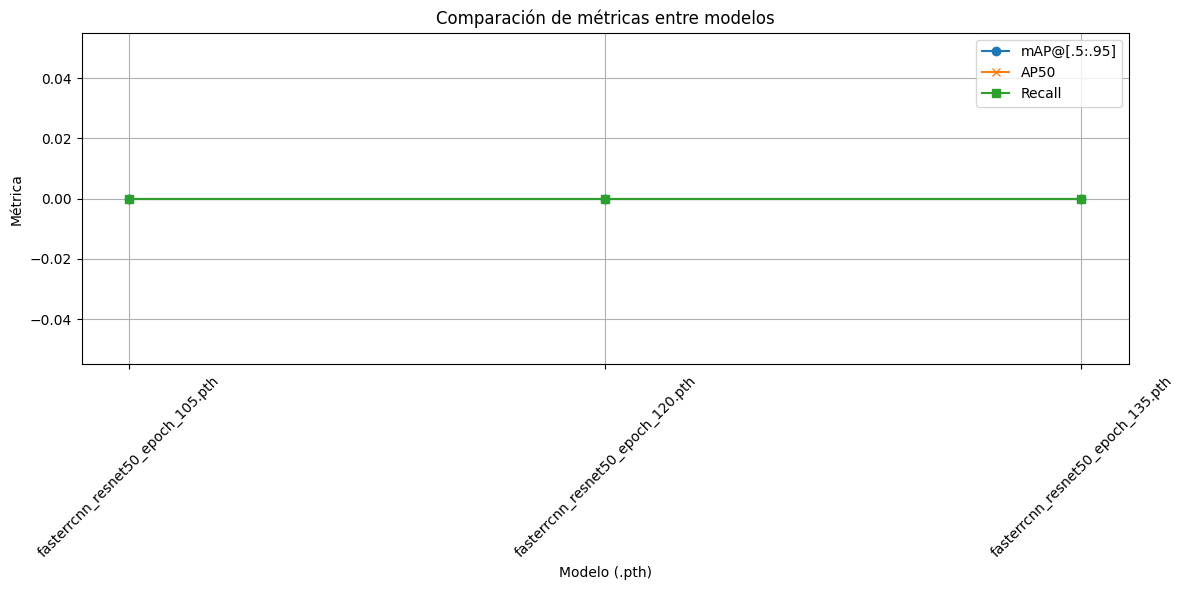


✅ Resultados exportados a 'resultados_comparacion_modelos.csv'


In [14]:
# --- COMPARAR VARIOS MODELOS .PTH ---
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def compare_models(model_paths, model, val_loader, annotations_path, device="cuda"):
    resultados = []
    for path in model_paths:
        model.load_state_dict(torch.load(path, map_location=device))
        print(f"\nEvaluando modelo: {path}")
        metrics = evaluate_model(model, val_loader, annotations_path, output_json="predictions_temp.json", device=device)
        resultados.append({
            "modelo": os.path.basename(path),
            "mAP@[.5:.95]": metrics["map"],
            "AP50": metrics["ap50"],
            "Recall": metrics["recall"],
            "Box Loss": metrics["box_loss"],
            "Cls Loss": metrics["cls_loss"]
        })

    df = pd.DataFrame(resultados)
    df_ordenado = df.sort_values(by="mAP@[.5:.95]", ascending=False)
    print("\n📊 Comparación de modelos:")
    print(df_ordenado.to_string(index=False))

    # --- GRAFICAR RESULTADOS ---
    plt.figure(figsize=(12, 6))
    plt.plot(df_ordenado['modelo'], df_ordenado['mAP@[.5:.95]'], label='mAP@[.5:.95]', marker='o')
    plt.plot(df_ordenado['modelo'], df_ordenado['AP50'], label='AP50', marker='x')
    plt.plot(df_ordenado['modelo'], df_ordenado['Recall'], label='Recall', marker='s')
    plt.xlabel("Modelo (.pth)")
    plt.ylabel("Métrica")
    plt.title("Comparación de métricas entre modelos")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # --- GUARDAR RESULTADOS EN CSV ---
    df_ordenado.to_csv("resultados_comparacion_modelos.csv", index=False)
    print("\n✅ Resultados exportados a 'resultados_comparacion_modelos.csv'")

    return df_ordenado


# --- EJECUCIÓN PRINCIPAL ---
if __name__ == "__main__":
    # Lista de modelos a comparar
    model_paths = [
        "/content/fasterrcnn_resnet50_epoch_105.pth",
        "/content/fasterrcnn_resnet50_epoch_120.pth",
        "/content/fasterrcnn_resnet50_epoch_135.pth"
    ]

    # Crear modelo base
    def get_model(num_classes):
        model = fasterrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        return model

    model = get_model(num_classes= 2)  # Ajusta según tu dataset
    device = "cuda" if torch.cuda.is_available() else "cpu"

     # Preparar val_loader
    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    val_dataset = CocoDetection(
        root="/content/AM_BoundingBox-14/valid",
        annFile="/content/AM_BoundingBox-14/valid/_annotations.coco.json",
        transform=transform
    )

    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    # Ruta a las anotaciones COCO del conjunto de validación
    annotations_path = "/content/AM_BoundingBox-14/valid/_annotations.coco.json"

    # Ejecutar comparación
    df_resultados = compare_models(model_paths, model, val_loader, annotations_path, device=device)


In [ ]:
 # --- GUARDAR RESULTADOS EN CSV ---
    df_ordenado.to_csv("resultados_comparacion_modelos.csv", index=False)
    print("\n✅ Resultados exportados a 'resultados_comparacion_modelos.csv'")

    return df_ordenado

In [15]:
# Guardar log por epoch
def log_training(epoch, loss, log_path="training_log.csv"):
    import csv, os
    file_exists = os.path.isfile(log_path)
    with open(log_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Epoch", "Loss"])
        writer.writerow([epoch, loss])


In [18]:
def evaluate_loss(model, dataloader, device):
    model.train()  # Necesario para calcular pérdida
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets if 'boxes' in t]

            if not targets:
                continue

            loss_dict = model(images, targets)
            loss = sum(l for l in loss_dict.values()).item()
            total_loss += loss
            count += 1

    return total_loss / count if count > 0 else float('nan')


In [20]:
import csv
import os

def log_losses(epoch, train_loss, val_loss, log_path="loss_log.csv"):
    file_exists = os.path.isfile(log_path)
    with open(log_path, mode='a', newline='') as log_file:
        writer = csv.writer(log_file)
        if not file_exists:
            writer.writerow(["Epoch", "Train_Loss", "Val_Loss"])
        writer.writerow([epoch, train_loss, val_loss])

In [ ]:
for epoch in range(num_epochs):
    loss = train_one_epoch(model, optimizer, train_loader, device, epoch)
    val_loss = evaluate_loss(model, val_loader, device)  # <- Debes implementar esta función si no la tienes
    log_losses(epoch, loss, val_loss)
    log_training(epoch, loss)  # 👈 Guarda aquí

Epoch [0] Loss: 0.3748
Epoch [1] Loss: 0.3331
Epoch [2] Loss: 0.3890
Epoch [3] Loss: 0.2808
Epoch [4] Loss: 0.2570
Epoch [5] Loss: 0.3191
Epoch [6] Loss: 0.3302
Epoch [7] Loss: 0.2962
Epoch [8] Loss: 0.2540
Epoch [9] Loss: 0.2886
Epoch [10] Loss: 0.3052
Epoch [11] Loss: 0.2912
Epoch [12] Loss: 0.2802
Epoch [13] Loss: 0.2725
Epoch [14] Loss: 0.2896
Epoch [15] Loss: 0.2930


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_train_val_losses(log_path="loss_log.csv"):
    if not os.path.exists(log_path):
        print("⚠️ No se encontró el archivo de log.")
        return

    df = pd.read_csv(log_path)

    plt.figure(figsize=(10, 5))
    plt.plot(df["Epoch"], df["Train_Loss"], label="Pérdida Entrenamiento", color="blue", marker='o')
    plt.plot(df["Epoch"], df["Val_Loss"], label="Pérdida Validación", color="orange", marker='x')
    plt.title("📉 Evolución de la Pérdida por Época")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
